------------------------------------------------------------------------
------------------------ Running Fixed Pipeline ------------------------
------------------------------------------------------------------------
Parameters: EPOCHS=30;   BATCH_SIZE=16;   N_SPLITS=5
     KFOLD_SEED=42;   Optimizer: adam;   Learning Rate: 0.0001
     Conv Filters: [32, 128, 128];   Dense Units: 128;   Dropout Conv: 0.4
     Dropout Dense: 0.3;   Pooling Type: avg
------------------------------------------------------------------------
Data shape: (600, 250, 250, 3), Labels shape: (600,)
Train shape: (480, 250, 250, 3), Test shape: (120, 250, 250, 3)
------------------------------------------------------------------------

--- Fold 1 ---
Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6141 - loss: 0.6389 - val_accuracy: 0.4271 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7021 - loss: 0.5856 - val_accuracy: 0.5312 - val

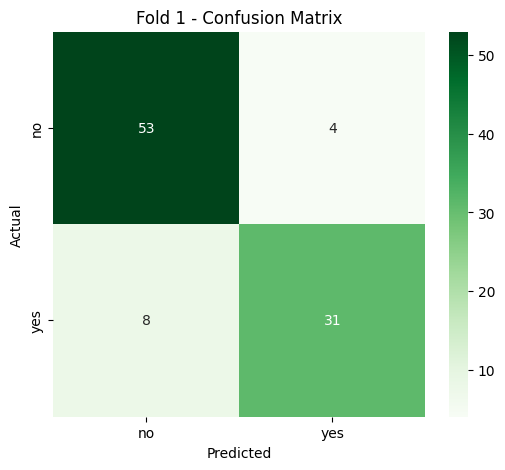

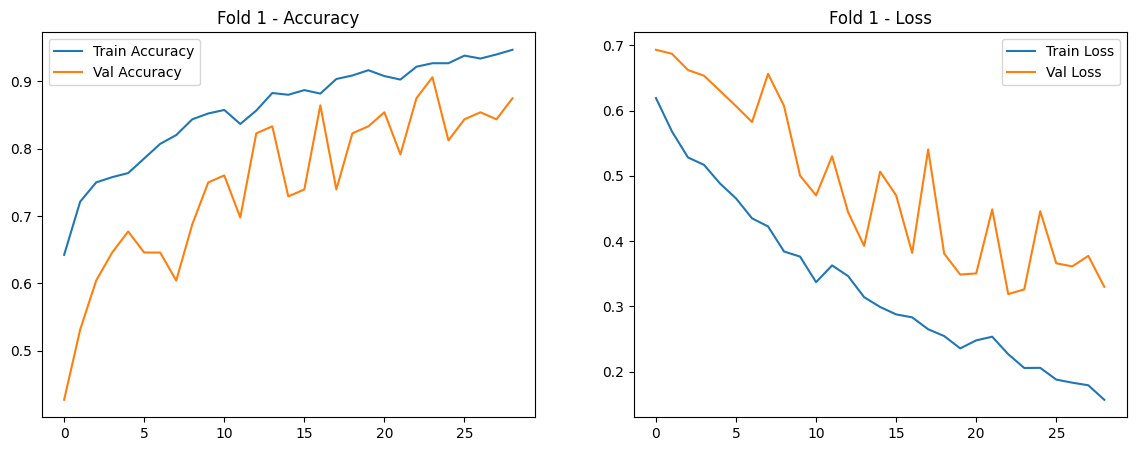


--- Fold 2 ---
Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6385 - loss: 0.6461 - val_accuracy: 0.4479 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.7144 - loss: 0.5585 - val_accuracy: 0.4479 - val_loss: 0.6989 - learning_rate: 1.0000e-04
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7292 - loss: 0.5493 - val_accuracy: 0.4479 - val_loss: 0.7220 - learning_rate: 1.0000e-04
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.7508 - loss: 0.5205 - val_accuracy: 0.4479 - val_loss: 0.7850 - learning_rate: 1.0000e-04
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.7601 - loss: 0.5189 - val_accuracy: 0.5833 - val_loss: 0.6731 - learning_rate: 1.0000e-04
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.7916 - loss: 0.4638 - val_accuracy: 0.6354 - val_loss: 0.6425 - learning_rate: 1.0000e-04
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy

In [ ]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from itertools import product
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import random


# Parameters for fixed pipeline
EPOCHS = 30             # Number of epochs (adjust as needed)
BATCH_SIZE = 16         # Batch size
KFOLD_SEED = 42         # KFold Seed
N_SPLITS = 5           # Number of KFold splits
optimizer_name = "adam"  # adam, rmsprop, sgd
learning_rate = 1e-4    # 1e-4, 5e-4, 1e-3
conv_filters = [32, 128, 128]  # Convolutional filters
dense_units = 128       # Dense layer units
dropout_conv = 0.4      # Dropout rate for conv layers
dropout_dense = 0.3    # Dropout rate for dense layers
pooling_type = "avg"    # Pooling type: "avg" or "max"


# Global parameters
LABELS = ['no', 'yes']  # Class labels
IMG_SIZE = 250          # Image resize
np.random.seed(42)      # Numpy Seed


def get_data(data_dir):
    X, y = [], []
    data_dir = Path(data_dir)
    for label in LABELS:
        path = data_dir / label
        class_num = LABELS.index(label)
        for img_file in path.iterdir():
            try:
                img_arr = cv2.imread(str(img_file))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                X.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(f"Error reading {img_file.name}: {e}")
    return np.array(X), np.array(y)

def augment_images(x, y):
    x_aug, y_aug = [], []

    for img, label in zip(x, y):
        x_aug.append(img)  # 1. original
        y_aug.append(label)

        # 2. random rotation
        k1 = np.random.choice([1, 2, 3])
        rotated = np.rot90(img, k1)
        x_aug.append(rotated)
        y_aug.append(label)

        # 3. different rotation (next clockwise) + flip
        k2 = 1 if k1 == 3 else k1 + 1
        rotated2 = np.rot90(img, k2)
        flipped = np.fliplr(rotated2)
        x_aug.append(flipped)
        y_aug.append(label)

    return np.array(x_aug), np.array(y_aug)

def create_model_with_tuning(conv_filters, dense_units, dropout_conv, dropout_dense, pooling_type, optimizer_name, learning_rate):
    model = Sequential()
    model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    for filters in conv_filters:
        model.add(Conv2D(filters, (3, 3), padding="same", activation="relu"))
        model.add(BatchNormalization())
        model.add(MaxPool2D(padding="same"))

    model.add(Dropout(dropout_conv))

    if pooling_type == "avg":
        model.add(GlobalAveragePooling2D())
    elif pooling_type == "max":
        model.add(GlobalMaxPooling2D())
    else:
        raise ValueError("Invalid pooling_type. Use 'avg' or 'max'.")

    model.add(Dense(dense_units, activation="relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation="sigmoid"))

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, x_train, y_train, x_val, y_val, custom_batch_size=BATCH_SIZE, custom_epochs=EPOCHS, custom_early_stop_p=5, custom_lr_p=3):
    early_stop = EarlyStopping(monitor='val_loss', patience=custom_early_stop_p, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=custom_lr_p, min_lr=1e-5)

    history = model.fit(
        x_train, y_train,
        batch_size=custom_batch_size,
        epochs=custom_epochs,
        validation_data=(x_val, y_val),
        callbacks=[early_stop, lr_scheduler],
        verbose=1,
        shuffle=True
    )
    return history

def plot_metrics(history, fold):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend()
    plt.title(f'Fold {fold} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title(f'Fold {fold} - Loss')
    plt.show()

def evaluate_model(model, x_val, y_val, fold):
    predictions = (model.predict(x_val) > 0.5).astype("int32").reshape(-1)
    print(classification_report(y_val.astype(int), predictions, target_names=LABELS))

    cm = confusion_matrix(y_val.astype(int), predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=LABELS, yticklabels=LABELS)
    plt.title(f'Fold {fold} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def train_test_split_data(x_data, y_data, test_size=0.2, random_state=42):
    return train_test_split(x_data, y_data, test_size=test_size, random_state=random_state, stratify=y_data)

def run_fixed_pipeline():
    # Load and normalize data once
    x_data, y_data = get_data('data')
    x_data = x_data / 255.0
    y_data = y_data.astype('float32')

    # Split into train and test sets (20% test)
    x_train, x_test, y_train, y_test = train_test_split_data(x_data, y_data, test_size=0.2, random_state=42)

    # KFold on train only
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=KFOLD_SEED)
    print("------------------------------------------------------------------------")
    print("------------------------ Running Fixed Pipeline ------------------------")
    print("------------------------------------------------------------------------")
    print(f"Parameters: EPOCHS={EPOCHS};   BATCH_SIZE={BATCH_SIZE};   N_SPLITS={N_SPLITS}")
    print(f"     KFOLD_SEED={KFOLD_SEED};   Optimizer: {optimizer_name};   Learning Rate: {learning_rate}")
    print(f"     Conv Filters: {conv_filters};   Dense Units: {dense_units};   Dropout Conv: {dropout_conv}")
    print(f"     Dropout Dense: {dropout_dense};   Pooling Type: {pooling_type}")
    print(f"------------------------------------------------------------------------")
    print(f"Data shape: {x_data.shape}, Labels shape: {y_data.shape}")
    print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")
    print(f"------------------------------------------------------------------------")

    x_train, x_test, y_train, y_test = train_test_split_data(x_data, y_data, test_size=0.2, random_state=42)
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=KFOLD_SEED)

    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(x_train), 1):
        print(f"\n--- Fold {fold} ---")
        x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        x_train_fold, y_train_fold = augment_images(x_train_fold, y_train_fold)

        model = create_model_with_tuning(conv_filters, dense_units, dropout_conv, dropout_dense, pooling_type, optimizer_name, learning_rate)
        history = train_model(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold, custom_batch_size=BATCH_SIZE, custom_epochs=EPOCHS, custom_early_stop_p=6, custom_lr_p=4)



        evaluate_model(model, x_val_fold, y_val_fold, fold)
        plot_metrics(history, fold)

        loss, acc = model.evaluate(x_val_fold, y_val_fold, verbose=0)
        fold_accuracies.append(acc)

        model_f1_score = 2 * (acc * acc) / (acc + acc) if acc + acc > 0 else 0
        model_accuracy_int = int(acc * 100)  # Convert to integer percentage
        # save model as .keras file
        datetime_str = datetime.datetime.now().strftime("%Y%m%d")
        model_name = f"model_fold_{fold}_{datetime_str}_acc_{model_accuracy_int}.keras"
        model.save(model_name)
    print(f"\nAverage validation accuracy over folds: {np.mean(fold_accuracies):.4f}")

    # Train final model on full train set and evaluate on test set
    '''
    final_model = create_model()
    final_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    test_loss, test_acc = final_model.evaluate(x_test, y_test, verbose=0)
    print(f"Final test accuracy: {test_acc:.4f}")
    '''

def main():
    run_fixed_pipeline()

if __name__ == "__main__":
    main()
